In [34]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using BenchmarkTools
using Random
using Plots

## State Estimation in a Linear Gaussian State-space Model with Kalman Filter

In this demo, the goal is to filter noisy observations by performing on-line inference with a state-space model (SSM).

We wil use the following model:

\begin{equation} \label{eq:linear_gaussian_ssm}
  \begin{aligned}
    \mathbf{x}_k & = \, \mathbf{A}_k\mathbf{x}_{k - 1} + \epsilon_k \\
    \mathbf{y}_k & = \, \mathbf{B}_k\mathbf{x}_{k} + \varepsilon_k \\
  \end{aligned}
\end{equation}
 
In this model, we denote by $\mathbf{x}_k$ the current state of the system (at time step $k$), by $\mathbf{x}_{k - 1}$ the previous state at time $k-1$, $\mathbf{A}_k$ and $\mathbf{B}_k$ are a constant system inputs and $\mathbf{y}_k$ is a noisy observation of $\mathbf{x}_k$. We further assume that the states and the observations are corrupted by i.i.d. Gaussian noise with variances $\epsilon_k$ and $\varepsilon_k$ respectively.

The SSM can be represented by the following Forney-style factor graph, where the pictured section is chained over time:

                 (u)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
For on-line (forward-only) estimation in ReactiveMP.jl, it suffices to build a single-time-step section of the model. We then iteratively infer the posterior statistics by considering one observation at a time. After each inference step, we pass the posterior statistics on as the new prior statistics, leading to an (exact) on-line filtering algorithm that is equivalent to Kalman filtering.

In [19]:
@model function linear_gaussian_ssm_filtering(n, A, B, P, Q)
    
    x_t_min_mean = datavar(Vector{Float64})
    x_t_min_cov  = datavar(Matrix{Float64})
    y            = datavar(Vector{Float64})
    
    z ~ MvGaussianMeanCovariance(x_t_min_mean, x_t_min_cov)
    x ~ MvGaussianMeanCovariance(A * z, P)
    y ~ MvGaussianMeanCovariance(B * x, Q)
    
    return x_t_min_mean, x_t_min_cov, x, y
end

linear_gaussian_ssm_filtering (generic function with 2 methods)

In [20]:
function generate_data(; seed, n, A, B, P, Q)
    Random.seed!(seed)

    x_prev = zeros(2)

    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i] = rand(MvNormal(A * x_prev, P))
        y[i] = rand(MvNormal(B * x[i], Q))

        x_prev = x[i]
    end
   
    return x, y
end

generate_data (generic function with 1 method)

In [21]:
seed = 1234
n = 100
θ = π / 15
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
B = [ 1.3 0.0; 0.0 0.7 ]
P = [ 1.0 0.0; 0.0 1.0 ]
Q = [ 1.0 0.0; 0.0 1.0 ]
θ = π / 15

real_x, real_y = generate_data(
    seed = seed,
    n    = n,
    A    = A,
    B    = B,
    P    = P,
    Q    = Q,
);

In [28]:
function inference(observations; A, B, P, Q)
    n = length(observations) 
    
    model, (x_t_min_mean, x_t_min_cov, x, y) = linear_gaussian_ssm_filtering(n, A, B, P, Q)
    
    xbuffer = Vector{Marginal}()
    
    update_step = (x_t_marginal) -> begin
        push!(xbuffer, x_t_marginal)
        current_x_t_min_mean = mean(x_t_marginal)
        current_x_t_min_cov  = cov(x_t_marginal)
    end
    
    xsub = subscribe!(getmarginal(x), update_step)
    
    current_x_t_min_mean = [ 0.0, 0.0 ]
    current_x_t_min_cov  = [ 100.0 0.0; 0.0 100.0 ]
    
    for t in 1:n
        update!(x_t_min_mean, current_x_t_min_mean)
        update!(x_t_min_cov, current_x_t_min_cov)
        update!(y, observations[t])
    end
    
    unsubscribe!(xsub)
    
    return xbuffer
end

inference (generic function with 1 method)

In [29]:
x_inferred = inference(real_y, A = A, B = B, P = P, Q = Q);

In [30]:
reshape_data(data) = transpose(reduce(hcat, data))

reshape_data (generic function with 1 method)

In [31]:
using PGFPlotsX

PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX)

pgfplotsx();

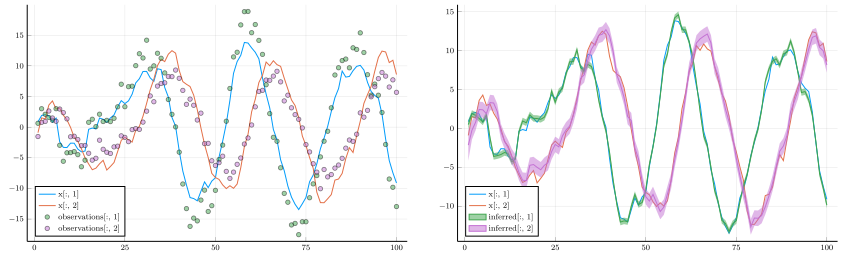

In [32]:
generated_data = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
generated_data = plot!(1:n, real_y |> reshape_data, seriestype = :scatter, ms = 3, alpha = 0.5, label = [ "observations[:, 1]" "observations[:, 2]" ])
generated_data = plot!(generated_data, legend = :bottomleft)

results_plot = plot(1:n, real_x |> reshape_data, label = [ "x[:, 1]" "x[:, 2]" ])
results_plot = plot!(results_plot, 1:n, mean.(x_inferred) |> reshape_data, ribbon = var.(x_inferred) |> reshape_data, label = [ "inferred[:, 1]" "inferred[:, 2]" ])
results_plot = plot!(results_plot, legend = :bottomleft)

plot(generated_data, results_plot, size = (1200, 400))

In [33]:
savefig(generated_data, "./plots/linear_gaussian_ssm_filtering_data.tikz")
savefig(results_plot, "./plots/linear_gaussian_ssm_filtering_inference.tikz")

In [35]:
import Pkg; Pkg.status(); versioninfo()

Status `~/Projects/LaTeX/RMP_Experiments/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [31c24e10] Distributions v0.24.12
  [b3f8163a] GraphPPL v0.1.0 `~/.julia/dev/GraphPPL.jl`
  [91a5bcdd] Plots v1.10.1
  [a194aa59] ReactiveMP v0.5.0 `~/.julia/dev/ReactiveMP`
  [df971d30] Rocket v1.3.3 `~/.julia/dev/Rocket`
Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
